In [ ]:
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

     |████████████████████████████████| 61kB 4.5MB/s 
--2021-03-06 04:57:13--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2021-03-06 04:57:13 (68.1 MB/s) - ‘signnames.csv’ saved [999/999]



2021-03-06 04:57:18.066 | WARNING  | torch_snippets.torch_loader:<module>:232 - Not importing Lightning Report
2021-03-06 04:57:18.171 | INFO     | torch_snippets.loader:Glob:221 - 39209 files found at GTSRB/Final_Training/Images/*/*.ppm
2021-03-06 04:57:18.808 | INFO     | __main__:__init__:46 - 29406
2021-03-06 04:57:18.809 | INFO     | __main__:__init__:46 - 9803


EPOCH: 1.000	trn_loss: 2.359	trn_acc: 0.293	val_loss: 1.637	val_acc: 0.464	(21.40s - 834.63s remaining)
EPOCH: 2.000	trn_loss: 1.338	trn_acc: 0.560	val_loss: 1.054	val_acc: 0.642	(42.21s - 802.04s remaining)
EPOCH: 3.000	trn_loss: 0.872	trn_acc: 0.709	val_loss: 0.763	val_acc: 0.752	(62.78s - 774.28s remaining)
EPOCH: 4.000	trn_loss: 0.641	trn_acc: 0.785	val_loss: 0.623	val_acc: 0.798	(83.75s - 753.71s remaining)
EPOCH: 5.000	trn_loss: 0.538	trn_acc: 0.821	val_loss: 0.586	val_acc: 0.810	(104.53s - 731.74s remaining)
EPOCH: 6.000	trn_loss: 0.472	trn_acc: 0.844	val_loss: 0.505	val_acc: 0.840	(125.18s - 709.34s remaining)
EPOCH: 7.000	trn_loss: 0.435	trn_acc: 0.858	val_loss: 0.460	val_acc: 0.850	(145.78s - 687.27s remaining)
EPOCH: 8.000	trn_loss: 0.398	trn_acc: 0.869	val_loss: 0.394	val_acc: 0.873	(166.57s - 666.28s remaining)
EPOCH: 9.000	trn_loss: 0.377	trn_acc: 0.877	val_loss: 0.388	val_acc: 0.877	(187.23s - 644.91s remaining)
EPOCH: 10.000	trn_loss: 0.364	trn_acc: 0.882	val_loss: 0.36

  0%|          | 0/141 [00:00<?, ?it/s]

EPOCH: 40.000	trn_loss: 0.120	trn_acc: 0.959	val_loss: 0.184	val_acc: 0.941	(822.21s - 0.00s remaining)


100%|██████████| 141/141 [00:03<00:00, 46.41it/s]


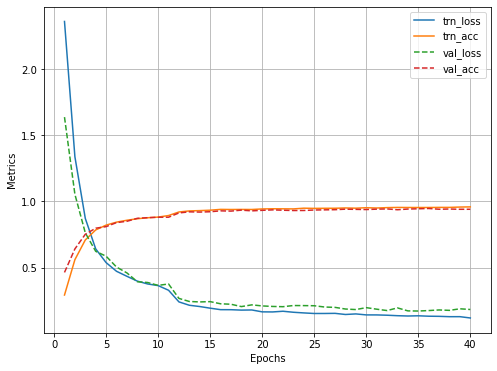

2021-03-06 05:11:15.717 | INFO     | torch_snippets.loader:dumpdill:366 - Dumped object of size `~2 MB` @ "no-aug-no-bn.log" in 1.49 seconds


In [ ]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')